$\textbf{x}\in\Omega$

$$\textbf{a}\cdot\nabla u =\varepsilon\nabla^2u - \sigma u + s$$

$$\int_\Omega\text{d}x~v\,\textbf{a}\cdot\nabla u + \varepsilon\nabla v\cdot\nabla u + v\sigma u - vs - \int_{\partial\Omega}\text{d}s~v\varepsilon\,\textbf{n}\cdot\nabla u=0 \qquad \forall v\in V$$

In [ ]:
import numpy as np
from ufl.core.expr import Expr
from ufl import (
    Form, CellDiameter, FacetNormal, dx, dS, 
    inner, grad, div, TestFunction, TrialFunction, Dx, 
    avg, sqrt, tanh, jump,
)

from lucifex.mesh import interval_mesh
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import BoundaryValueProblem, bvp_solver, BoundaryConditions
from lucifex.viz import plot_line
from lucifex.utils.py_utils import nested_dict


def steady_advection_diffusion(
    u: Function, 
    a: Function | Constant, 
    eps: Constant, 
    sigma: Function | Constant | None = None,
    s: Function | Constant | None = None,
    bcs: BoundaryConditions | None = None,
    stabilization: str | None = None,
) -> list[Form]:
    
    stabilization = str(stabilization).lower()
    v = TestFunction(u.function_space)
    u_trial = TrialFunction(u.function_space)
    h = CellDiameter(u.function_space.mesh)

    if stabilization in ('supg', 'gls'):
        forms = steady_advection_diffusion(u, a, eps, sigma, s, bcs)
        res = inner(a, grad(u_trial)) - eps * div(grad(u_trial))
        if sigma is not None:
            res += sigma * u_trial
        if s is not None:
            res -= s
        Pe = peclet(h, a, eps)
        beta = (1 / tanh(Pe)) -  (1 / Pe)
        tau = 0.5 * beta * h / sqrt(inner(a, a))
        if stabilization == 'supg':
            Pv = inner(a, grad(v))
        if stabilization == 'gls':
            Pv = inner(a, grad(v)) - eps * div(grad(v))
            if sigma is not None:
                Pv += sigma * v
        Fsupg = tau * Pv * res * dx
        forms.append(Fsupg)
        return forms

    if stabilization.startswith('su'):
        assert u.function_space.mesh.geometry.dim == 1
        forms = steady_advection_diffusion(u, a, eps, sigma, s, bcs)
        if stabilization.endswith('upwind'):
            beta = Constant(u.function_space.mesh, 1.0)
        elif stabilization.endswith('optimal'):
            Pe = peclet(h, a, eps)
            beta = (1 / tanh(Pe)) -  (1 / Pe)
        else:
            raise ValueError('su_upwind or su_optimal')
        Fsu = 0.5 * beta * h * Dx(v, 0) * inner(a, grad(u_trial)) * dx
        forms.append(Fsu)
        return forms
    
    if stabilization == 'dg':
        return steady_advection_diffusion(u, a, eps, sigma, s, bcs)
    
    assert stabilization == 'none'
    Fa = v * inner(a, grad(u_trial)) * dx
    Fd = eps * inner(grad(v), grad(u_trial)) * dx
    forms = [Fa, Fd]

    if sigma is not None:
        Fr = v * sigma * dx
        forms.append(Fr)
    if s is not None:
        Fs = -v * s * dx 
        forms.append(Fs)
    if bcs is not None:
        ds, neumann_data = bcs.boundary_data(u.function_space, 'neumann')
        F_neumann = sum([-v * uN * ds(i) for i, uN in neumann_data])
        forms.append(F_neumann)

    return forms


def steady_advection_diffusion_dg(
    u: Function, 
    a: Function | Constant, 
    eps: Constant, 
    sigma: Function | Constant | None = None,
    s: Function | Constant | None = None,
    bcs: BoundaryConditions | None = None,
):
    v = TestFunction(u.function_space)
    u_trial = TrialFunction(u.function_space)
    h = CellDiameter(u.function_space.mesh)
    n = FacetNormal(u.function_space.mesh)

    aOut = 0.5 * (inner(a, n) + abs(inner(a, n)))
    aIn = 0.5 * (inner(a, n) - abs(inner(a, n)))

    Fa = inner(jump(v), aOut('+') * u('+') - aIn('-') * u('-')) * dS
    Fd = eps * inner(jump(v), jump(u_trial)) / avg(h)
    forms = [Fa, Fd]
    if sigma is not None:
        Fr = v * sigma * dx
        forms.append(Fr)
    if s is not None:
        Fr = -v * s * dx 
        forms.append(Fr)
    if bcs is not None:
        ds, dirichlet_data = bcs.boundary_data(u.function_space, 'dirichlet')
        raise NotImplementedError

    return forms


def peclet(h, a, eps) -> Expr | float:
    if all(isinstance(i, (float, int)) for i in (h, a, eps)):
        return 0.5 * a * h / eps
    return 0.5 * sqrt(inner(a, a)) * h / eps


### $d=1$

$$\Omega = [0, L_x]$$
$$\textbf{a}=a\,\textbf{e}_x$$
$$\sigma=0$$
$$s = 1$$

In [ ]:
def adr_solver_1d(
    stabilization: str | None,
    Lx: float,
    Nx: int,
    dirichlet: tuple[float, float],
    eps: float, 
    a: float,
    sigma: float | None,
    s: float | None,
) -> tuple[BoundaryValueProblem, float]:
    mesh = interval_mesh(Lx, Nx)
    h = Lx / Nx

    Pe = peclet(h, a, eps)
    a = Constant(mesh, (a, ), name='a')
    eps = Constant(mesh, eps, name='eps')
    if sigma is not None:
        sigma = Constant(mesh, sigma, 'sigma')
    if s is not None:
        s = Constant(mesh, s, name='s')
    u = Function((mesh, 'P', 1), name='u')
    
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0], dirichlet[0]),
        ('dirichlet', lambda x: x[0] - Lx, dirichlet[1])
    )

    if stabilization == 'dg':
        bcs_strong = None
        bcs_weak = bcs
    else:
        bcs_strong = bcs,
        bcs_weak = None

    u_solver = bvp_solver(steady_advection_diffusion, bcs=bcs_strong)(
        u, a, eps, sigma, s, bcs_weak, stabilization,
    )

    return u_solver, Pe


a = 1.0
sigma = None
s = 1.0 
dirichlet = (0.0, 0.0)
Lx = 1.0
Nx = 10

stabilizations = (None, 'SUPG', 'GLS', 'SU upwind')
epsilons = (0.2, 1/18, 1/100)

results: dict[float, dict[str | None, Function]] = nested_dict(2)
peclets: dict[float, float] = {}

for eps in epsilons:
    for stbl in stabilizations:
        u_solver, Pe = adr_solver_1d(stbl, Lx, Nx, dirichlet, eps, a, sigma, s)
        u_solver.solve()
        results[Pe][stbl] = u_solver.solution
    peclets[Pe] = eps

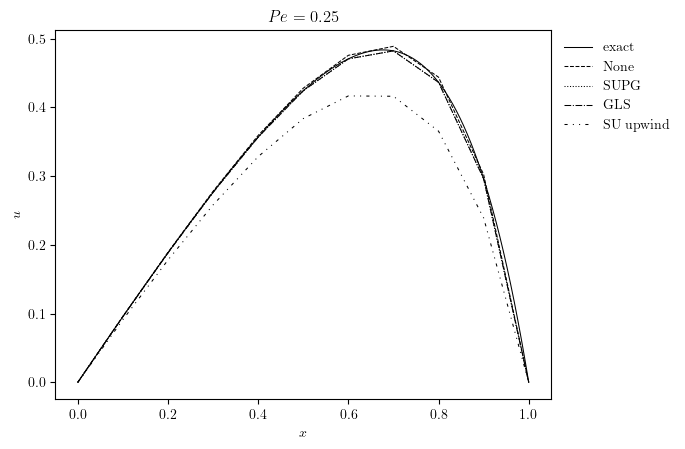

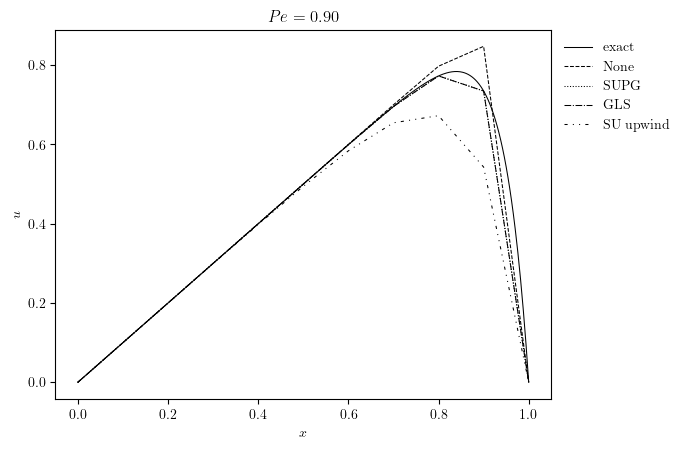

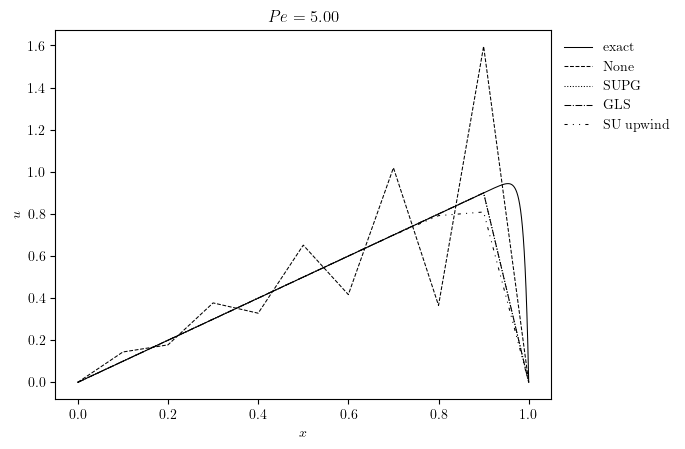

In [21]:
def exact_1d(
    x: np.ndarray, 
    a: float, 
    eps: float,
) -> np.ndarray:    
    return (1 / a) * (x - (1 - np.exp(a / eps * x)) / (1.0 - np.exp(a / eps)))

x = np.linspace(0, Lx, num=500)

for Pe, stbl_u in results.items():
    legend_labels = ['exact', *stbl_u.keys()]
    lines = [(x, exact_1d(x, a, peclets[Pe])), *(u for u in stbl_u.values())]
    plot_line(lines, legend_labels, x_label='$x$', y_label='$u$', title=f'$Pe={Pe:.2f}$')